<a href="https://colab.research.google.com/github/flaviovdf/musica/blob/main/notebooks/lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Descomente e rode para usar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-kmpekm7n
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-kmpekm7n
     |████████████████████████████████| 207 kB 23.6 MB/s 
     |████████████████████████████████| 126 kB 56.2 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
  Created wheel for musica-dcc-ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3414 sha256=069b4c53b4aff48c3376c555ba3449800218f90207ed901a7811c965a685886f
  Stored in directory: /tmp/pip-ephem-wheel-cache-w22tq6ej/wheels/94/cb/e0/72e4ee72153bf78a970722ac92a93e8a8f31c1853e32a3d1bc
Successfully built musica-dcc-ufmg


# Decomposição de Matrizes Musicais

**Objetivos**
1. Revisar Decomposição de Matrizes
1. Revisar SVD
1. Aprender um pouco sobre NMF

**Resultado Esperado**
1. Saber fazer uso do SKLearn para separar instrumentos

In [2]:
from μsica import μsf
from μsica import μsp

from numba import jit

import jax.numpy as jnp
import jax

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [3]:
μsp.init_matplotlib()
plt.ion()

In [4]:
μsf.download('https://dcc.ufmg.br/~flaviovdf/mir/lab08/IDMT-SMT-DRUMS-V2.zip',
             'files.zip', False)
μsf.extract('files.zip', '.')

files.zip: 274MB [00:16, 17.7MB/s]


## Introdução

Como vimos em sala de aula, a tarefa de separação de fontes (*source separation*) serve para extrair diferentes padrões de aúdio que se repetem em uma música. Aqui, um padrão pode ser visto como informação redundante na matriz do espectrograma de tempo curto. Como tal padrão se repete, a separação de fontes visa capturar os diferentes instrumentos tocados na música.

## Decomposição em Valores Singulares

Em álgebra linear, a decomposição em valores singulares ou singular value decomposition (SVD) é a fatoração de uma matriz real ou complexa, com diversas aplicações importantes em processamento de sinais e estatística.

Formalmente, a decomposição em valores singulares de uma matriz m×n real ou complexa X é uma fatoração ou fatorização na forma: 

$$ X = U \Sigma V^{*} $$ 

Aqui, $U$ é a matriz de vetores singulares à direita. $\Sigma$ é uma matriz diagonal com os valores singulares. Por fim, $V^{*}$ é a transposta conjugada dos valores singulares à direita. *Possivelmente você deve estar pensando: "massa, um monte de termo que sei muito pouco sobre"*. Se este é o seu caso, não se preocupe! Vamos tentar focar em uma ideia mais simples de SVD.

Para tal, uma outra forma de escrever tal equação é:

$$ X = U_s V^{t} $$ 

onde, $U_s = U \Sigma$, ou seja, o produto da primeira parte da equação acima. Aqui, $V^{t}$ é simplesmente transposta de $V$. Não vamos nos preocupar com transpostas conjugadas pois vamos trabalhar com números reais.

Em sua forma correta, $ X = U \Sigma V^{*} $, SVD consegue decompor qualquer matriz, $X$, real ou complexa. A decomposição também vai ser complexa, isto é, $U$, $\Sigma$ e $V$ podem conter números complexos. É importante ressaltar este fato para deixar claro que SVD consegue trabalhar no espectrograma complexo caso seja necessário. Fazemos uso da versão modificada aqui, pois conseguimos visualizar o espectro usando a norma dos números complexos, ou seja, um valor real.

Antes de começar vamos olhar para o espectrograma de um pequeno trecho musical.

In [5]:
μsf.download('http://dcc.ufmg.br/~flaviovdf/mir/examples/drum.wav', 'drum.wav',
             False)

drum.wav: 331kB [00:03, 99.8kB/s]


In [6]:
wav, sr = librosa.load('drum.wav')
ipd.Audio(wav, rate=sr)

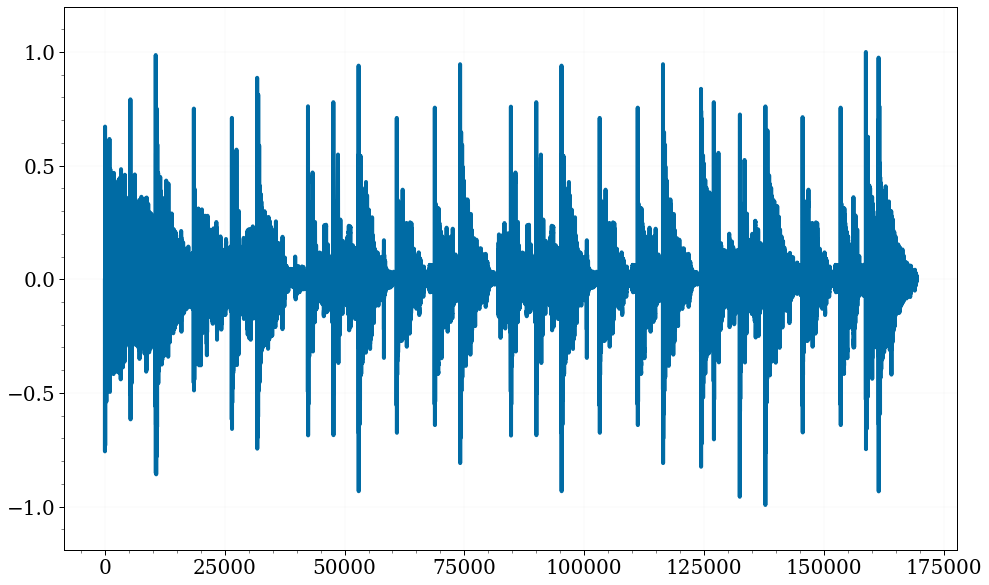

In [7]:
plt.plot(wav)

Observe como o espectrograma é uma matriz de valores complexas

In [8]:
S = librosa.stft(wav)
S[1, 0]

(21.010492-2.903927e-15j)

In [9]:
S.real

array([[-2.04294434e+01, -9.60280991e+00,  8.57357323e-01, ...,
         2.86548818e-03,  2.77445111e-02,  1.50528997e-01],
       [ 2.10104923e+01, -1.22868609e+00, -5.03100574e-01, ...,
        -2.04157755e-02,  7.20952218e-03, -6.23248741e-02],
       [-2.65991325e+01,  1.11167183e+01,  2.21814632e+00, ...,
         1.98108591e-02,  2.22539827e-02, -1.32204458e-01],
       ...,
       [-1.06431765e-03,  6.45676104e-04,  5.56440573e-05, ...,
         2.59905064e-05,  3.07723647e-04, -2.18525412e-03],
       [ 9.81305144e-04, -3.17966886e-04, -2.34028790e-04, ...,
        -1.96095876e-04, -1.19744625e-04, -1.15760497e-03],
       [-6.83862483e-04,  5.79404514e-05,  3.53292795e-04, ...,
         3.19004641e-04,  5.40562265e-04,  3.09617771e-03]], dtype=float32)

In [10]:
S.imag

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.9039271e-15,  1.0714315e+01, -2.4061909e-01, ...,
        -5.8182417e-03,  1.4468883e-02,  1.1686841e-01],
       [-4.6189223e-15,  3.4777143e+00, -4.1857952e-01, ...,
         3.1232927e-02, -3.4713306e-02, -9.1028683e-02],
       ...,
       [ 1.7803019e-16,  3.2414848e-04, -2.9644073e-04, ...,
        -1.3354661e-04, -3.1610118e-05,  2.0205786e-03],
       [ 5.1694760e-16, -6.9710822e-04,  3.7518269e-04, ...,
        -8.7013963e-05, -2.8488161e-05, -2.5324591e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

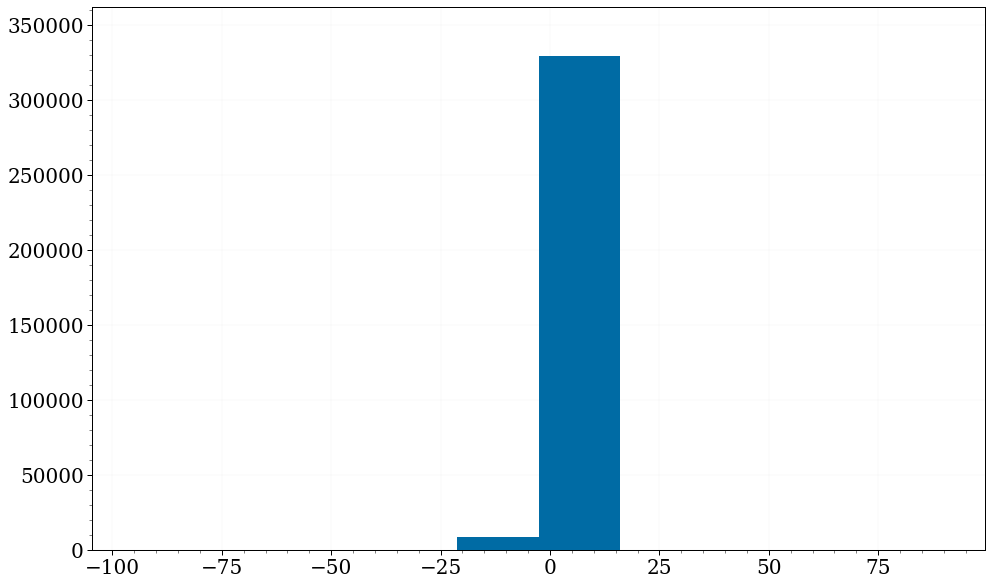

In [11]:
plt.hist(S.imag.ravel());

Com, `np.abs` pegamos a norma do número complexo. Isto é, sendo $z$ o valor complexo, $z = a + i\cdot b$, então sua norma é $|z| = \sqrt{a^2 + b^2}$.

Vamos guardar também o ângulo.

In [12]:
X = np.abs(S)
A = np.angle(S)

In [13]:
def plot_spec(X, fig=None, ax=None, color=True):
    '''Aqui X tem que ser o absoluto'''

    if fig is None and ax is None:
        fig, ax = plt.subplots()

    X_db = librosa.amplitude_to_db(X, ref=np.max)
    img = librosa.display.specshow(X_db, x_axis='time', y_axis='log', ax=ax)
    if color:
        fig.colorbar(img, ax=ax, format="%+2.f dB");

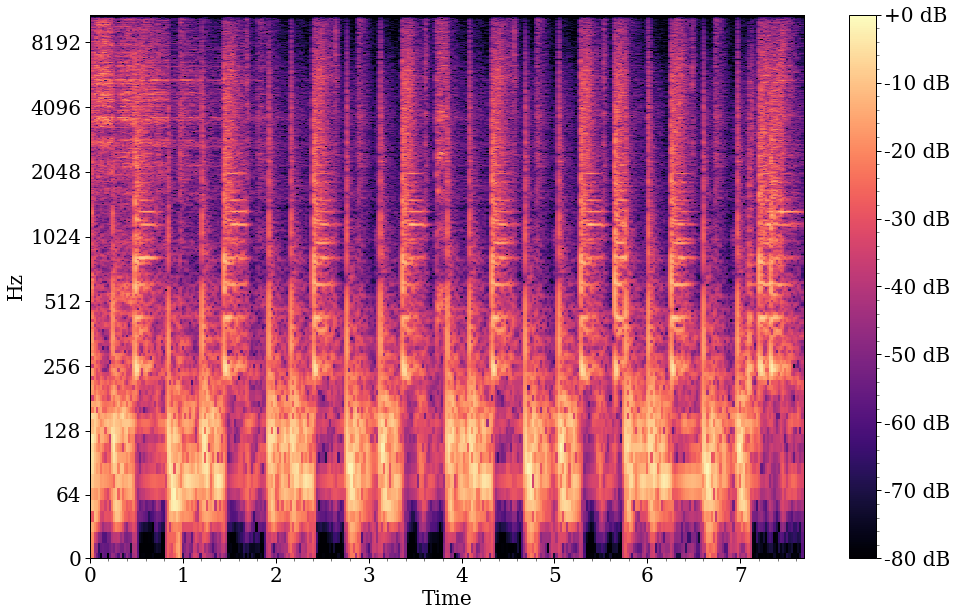

In [ ]:
plot_spec(X)

In [ ]:
### Qual a ideia de SVD?

In [ ]:
@jax.jit
def svd_loss(Us, Vh, X):
    X_model = Us @ Vh
    return jnp.mean((X - X_model) ** 2)

In [ ]:
grad_fn = jax.grad(svd_loss, argnums=(0, 1))

In [ ]:
k = 3
rows, cols = X.shape
Us = jnp.array(np.random.normal(size=(rows, k)))
Vh = jnp.array(np.random.normal(size=(k, cols)))

lr = 10
for i in range(5000):
    Us_prime, Vh_prime = grad_fn(Us, Vh, X)
    Us = Us - lr * Us_prime
    Vh = Vh - lr * Vh_prime
    if i % 100 == 0:
        print(i, svd_loss(Us, Vh, X))

0 12.597522
100 3.569331
200 2.3401315
300 2.2467601
400 2.1213367
500 2.0530775
600 2.0287256
700 2.017957
800 2.0110347
900 2.0056772
1000 2.0013351
1100 1.9978235
1200 1.9950229
1300 1.9928257
1400 1.9911263
1500 1.9898286
1600 1.988846
1700 1.9881086
1800 1.9875579
1900 1.9871491
2000 1.9868461
2100 1.9866222
2200 1.9864566
2300 1.9863349
2400 1.9862454
2500 1.9861796
2600 1.9861311
2700 1.9860958
2800 1.9860696
2900 1.9860502
3000 1.9860363
3100 1.9860263
3200 1.9860189
3300 1.9860128
3400 1.9860088
3500 1.9860063
3600 1.986004
3700 1.9860022
3800 1.9860007
3900 1.9860003
4000 1.9859995
4100 1.9859986
4200 1.9859989
4300 1.9859983
4400 1.9859985
4500 1.9859982
4600 1.9859982
4700 1.9859978
4800 1.9859978
4900 1.9859978


In [ ]:
def recover_from_one(Us, Vh, factor):
    right = Us[:, factor][:, np.newaxis]
    left = Vh[factor][np.newaxis]
    return right.dot(left)

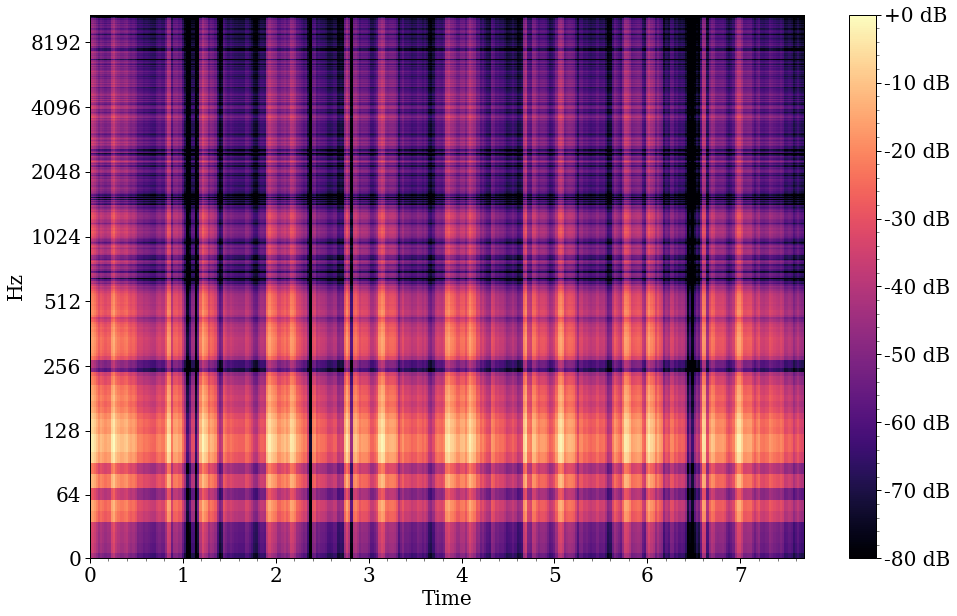

In [ ]:
X_model = recover_from_one(Us, Vh, 0)
plot_spec(X_model)

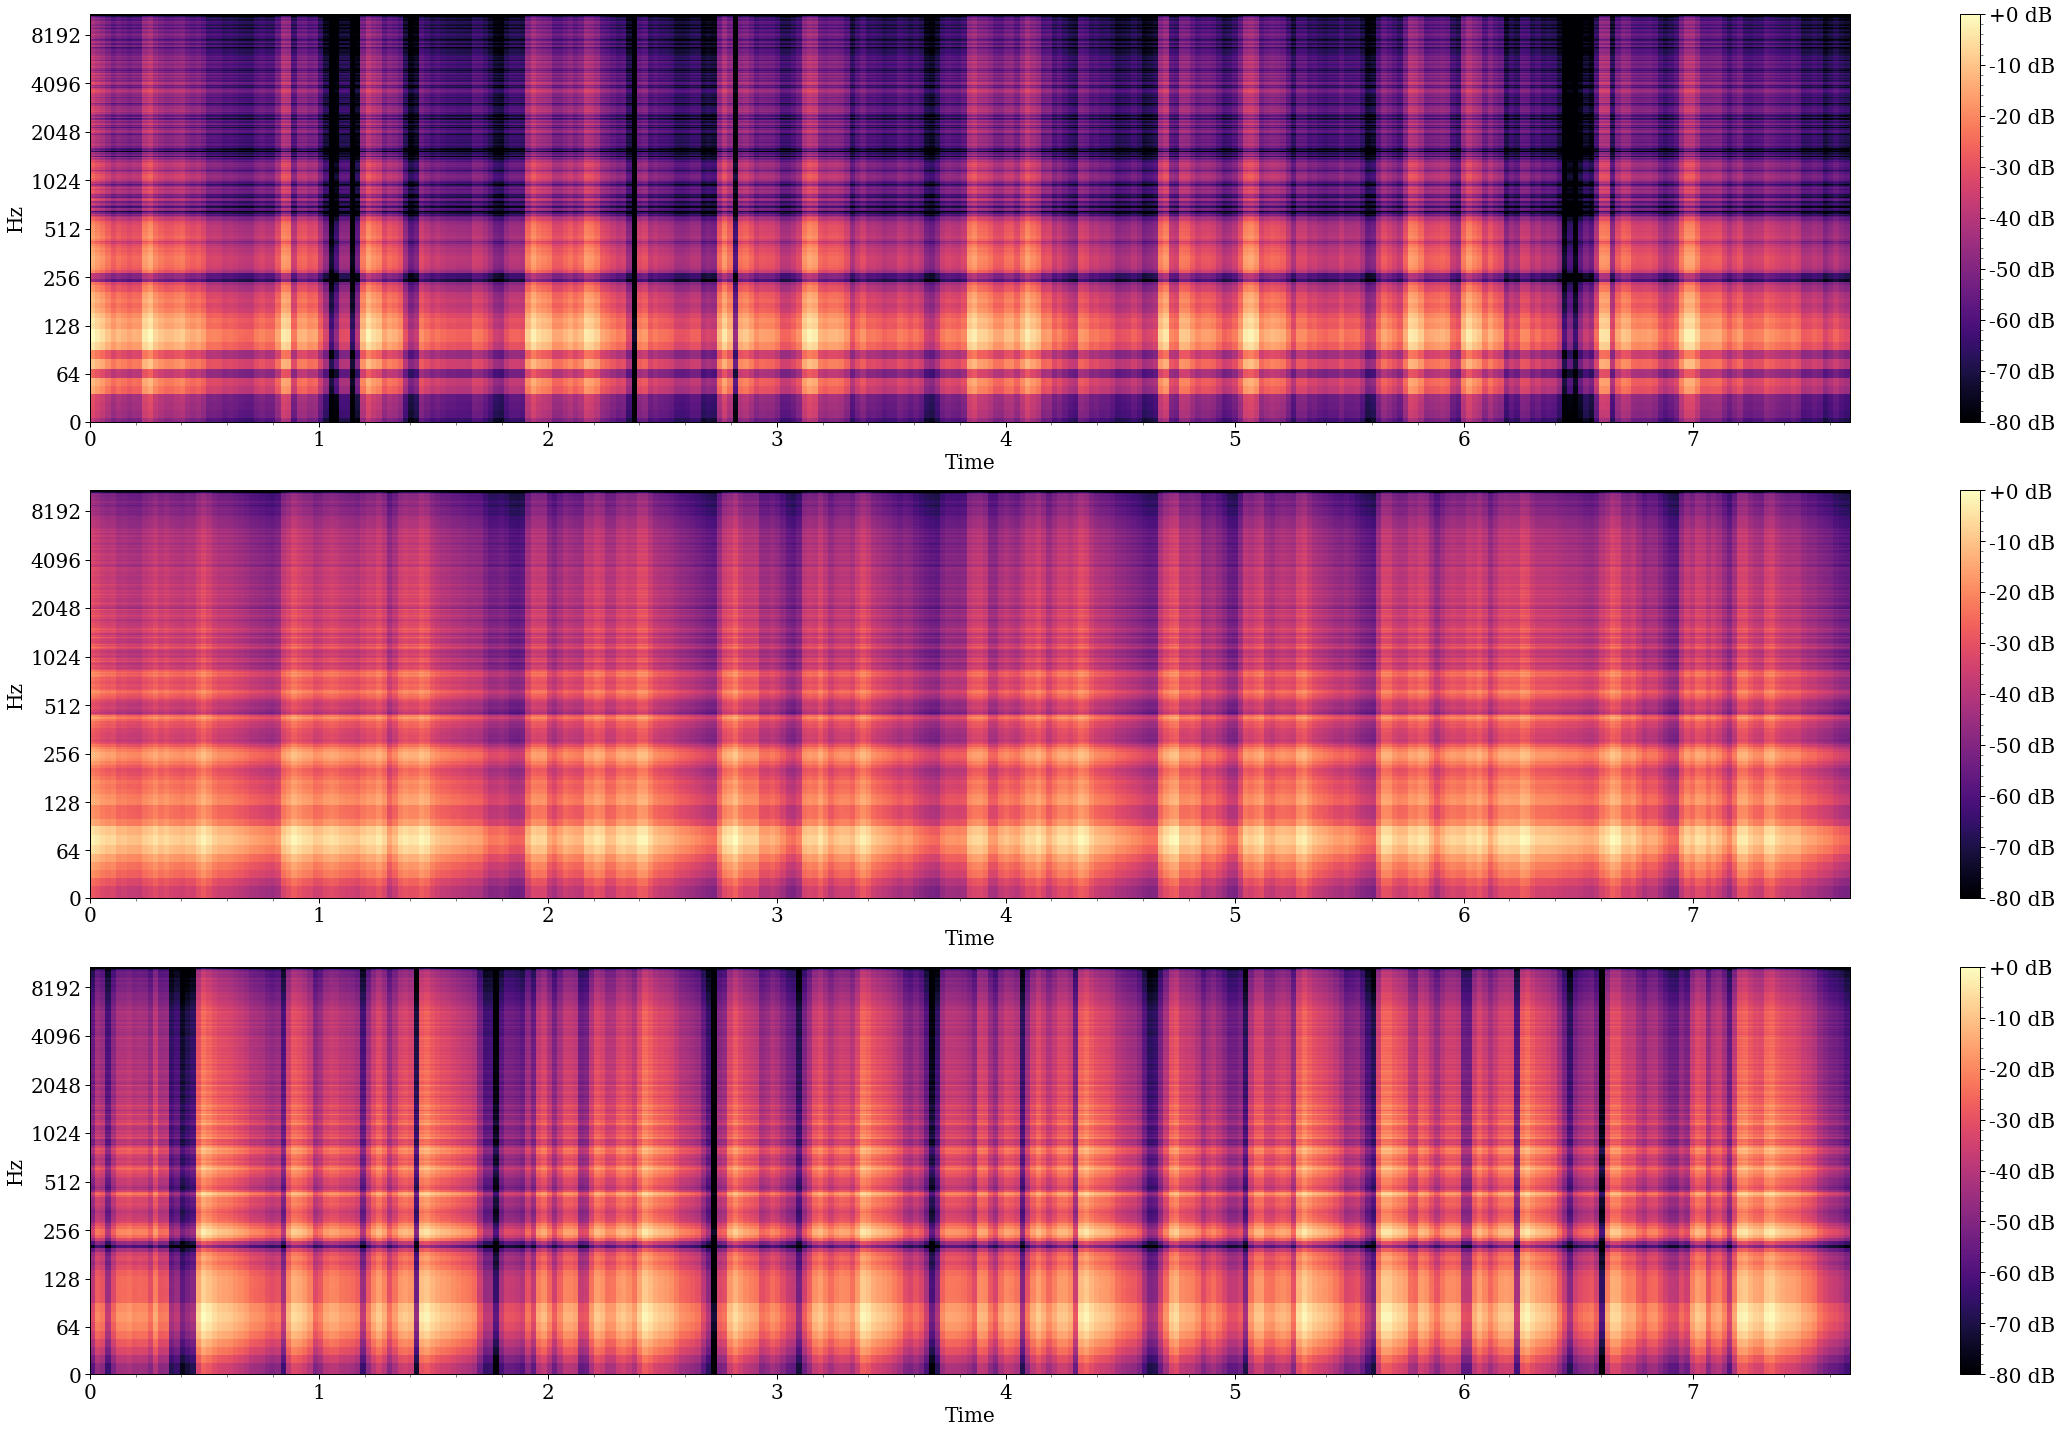

In [ ]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(Us, Vh, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

In [ ]:
X_model = recover_from_one(Us, Vh, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(Us, Vh, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
W = jnp.array(np.random.uniform(size=(rows, k)))
H = jnp.array(np.random.uniform(size=(k, cols)))

In [ ]:
k = 5
W = jnp.array(np.random.uniform(size=(rows, k)))
H = jnp.array(np.random.uniform(size=(k, cols)))

lr = 10
for i in range(5000):
    W = W * ((X @ H.T) / (((W @ H) @ H.T) + 0.0001))
    H = H * ((W.T @ X) / (((W.T @ W) @ H) + 0.0001))
    if i % 100 == 0:
        print(i, svd_loss(W, H, X))

0 4.670769
100 1.4946281
200 1.4939051
300 1.4937782
400 1.4937404
500 1.4937254
600 1.4937183
700 1.4937148
800 1.4937123
900 1.4937103
1000 1.493709
1100 1.493708
1200 1.4937074
1300 1.4937068
1400 1.493706
1500 1.4937059
1600 1.4937057
1700 1.4937055
1800 1.4937052
1900 1.493705
2000 1.493705
2100 1.4937047
2200 1.4937048
2300 1.4937048
2400 1.4937046
2500 1.4937047
2600 1.4937047
2700 1.4937047
2800 1.4937047
2900 1.4937047
3000 1.4937044
3100 1.4937047
3200 1.4937044
3300 1.4937047
3400 1.4937047
3500 1.4937047
3600 1.4937047
3700 1.4937049
3800 1.4937049
3900 1.4937048
4000 1.4937047
4100 1.4937048
4200 1.4937047
4300 1.4937047
4400 1.4937048
4500 1.4937048
4600 1.4937048
4700 1.4937049
4800 1.4937047
4900 1.4937049


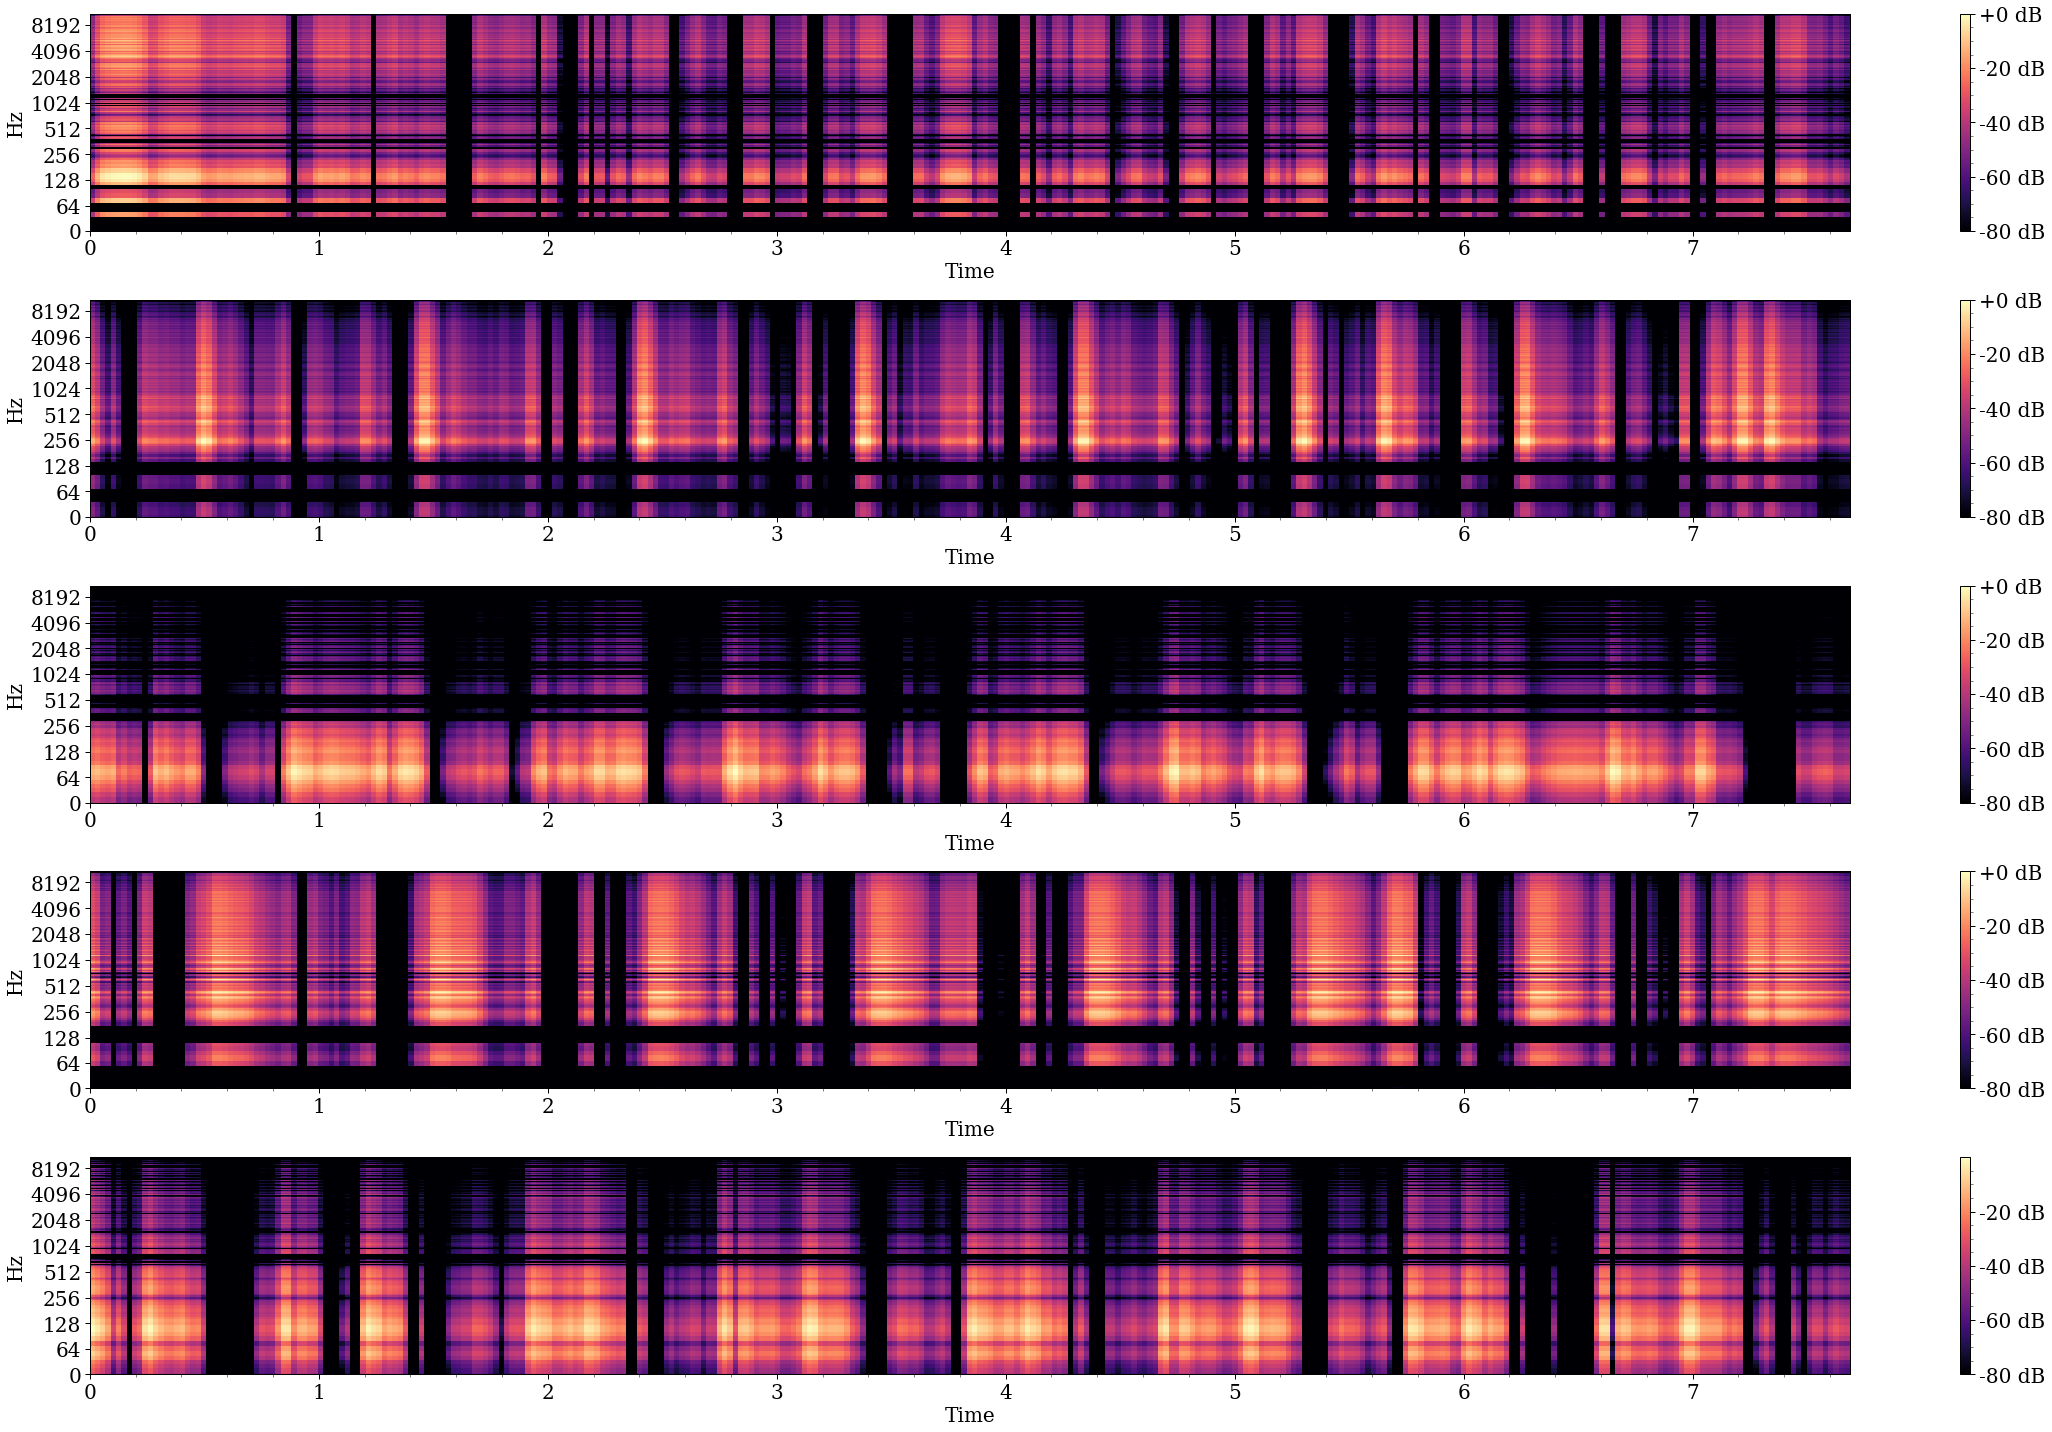

In [ ]:
fig, axes = plt.subplots(k, 1, figsize=(32, 20))
for i in range(k):
    X_model = recover_from_one(W, H, i)
    plot_spec(X_model, fig, axes[i])
fig.tight_layout()

In [ ]:
X_model = recover_from_one(W, H, 0)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(W, H, 1)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(W, H, 2)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(W, H, 3)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)

In [ ]:
X_model = recover_from_one(W, H, 4)
S_model = X_model * np.exp(1j * A)
wav_model = librosa.istft(np.asarray(S_model))
ipd.Audio(wav_model, rate=sr)